# SWB Computational Models

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import scipy.stats as stats
import pandas as pd
import scipy
from scipy.optimize import least_squares
import sklearn
from sklearn.metrics import r2_score
import random
import os
from statannot import add_stat_annotation



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

In [4]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

#/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/figs

In [5]:
#get swb bdi and bai 
raw_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_raw/'
subj_bdi = []
subj_bai = []
for subj_id in subj_ids:
    raw_data_dir = f'{raw_dir}{subj_id}/'
    raw_data_files = os.listdir(raw_data_dir)
    #load task data
    #load swb bdi and bai info to add to mood df
    raw_bdi_name = [x for x in raw_data_files if 'BDI' in x] #not all subj have BDI
    if raw_bdi_name:
        raw_bdi = pd.read_table(raw_data_dir+raw_bdi_name[0]) 
        bdi = raw_bdi['BDI Score'].iloc[-1]   
    else:
        bdi = 0
    subj_bdi.append(bdi)

    #bai loading (not all subj have BAI)
    raw_bai_name = [x for x in raw_data_files if 'BAI' in x]
    if raw_bai_name:
        raw_bai = pd.read_table(raw_data_dir+raw_bai_name[0]) 
        bai = raw_bai['BAI Score'].iloc[-1]   
    else:
        bai = 0
    subj_bai.append(bai)


In [6]:
subj_bdi

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 10, 9, 22, 32, 19, 39, 15]

# CPE Models

In [7]:
date = '09072023'
model_input_path = f'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/model_input_data_{date}'
model_input = pd.read_csv(model_input_path)


In [8]:
model_input.columns

Index(['subj_id', 'round', 'rate', 'zscore_rate', 'cr(t-1)', 'cr(t-2)',
       'cr(t-3)', 'choice_ev(t-1)', 'choice_ev(t-2)', 'choice_ev(t-3)',
       'rpe(t-1)', 'rpe(t-2)', 'rpe(t-3)', 'totalcpe(t-1)', 'totalcpe(t-2)',
       'totalcpe(t-3)', 'decisioncpe(t-1)', 'decisioncpe(t-2)',
       'decisioncpe(t-3)', 'totalregret(t-1)', 'totalregret(t-2)',
       'totalregret(t-3)', 'decisionregret(t-1)', 'decisionregret(t-2)',
       'decisionregret(t-3)', 'totalrelief(t-1)', 'totalrelief(t-2)',
       'totalrelief(t-3)', 'decisionrelief(t-1)', 'decisionrelief(t-2)',
       'decisionrelief(t-3)'],
      dtype='object')

In [9]:
model1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)"]
model2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]


model3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]

model5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]

model7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
model8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)"]


model9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

model11_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model12_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

model13_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
model14_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)"]

model15_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model16_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

model17_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model18_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

model19_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]
model20_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]

model21_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]
model22_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [10]:
models_dict = {}
models_dict['CR_EV'] = model1_vars
models_dict['RPE'] = model2_vars
models_dict['tCPE'] = model3_vars
models_dict['dCPE'] = model4_vars
models_dict['RPE_tCPE'] = model5_vars
models_dict['RPE_dCPE'] = model6_vars
models_dict['tRegret'] = model7_vars
models_dict['dRegret'] = model8_vars
models_dict['tRelief'] = model9_vars
models_dict['dRelief'] = model10_vars
models_dict['tRegret_tRelief'] = model11_vars
models_dict['dRegret_dRelief'] = model12_vars
models_dict['RPE_tRegret'] = model13_vars
models_dict['RPE_dRegret'] = model14_vars
models_dict['RPE_tRelief'] = model15_vars
models_dict['RPE_dRelief'] = model16_vars
models_dict['RPE_tRegret_tRelief'] = model17_vars
models_dict['RPE_dRegret_dRelief'] = model18_vars
models_dict['tRegret_dRelief'] = model19_vars
models_dict['dRegret_tRelief'] = model20_vars
models_dict['RPE_tRegret_dRelief'] = model21_vars
models_dict['RPE_dRegret_tRelief'] = model22_vars



In [11]:
#### run swb to find optimal parameters 
models_list = list(models_dict.keys())
lam_method = 'exp'

models_results = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    models_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [12]:
### use optimal parameters to run model 
models_data = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = models_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    models_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [13]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_model_bic = []
    for model in models_list[1:]:
        bic = models_data[model]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
    print('best model bic for ',s,'is',best_model_bic,best_bic)

best model bic for  DA8 is dRelief 33.88568826737055
best model bic for  DA9 is tRelief 34.38653132546847
best model bic for  DA10 is tRelief 34.34537028542505
best model bic for  DA11 is dRegret 34.568725938776296
best model bic for  DA023 is tRegret 34.46840918879103
best model bic for  MS002 is RPE 34.51450794552325
best model bic for  MS003 is dRegret 34.5689793111034
best model bic for  MS016 is dRelief 34.63011256628067
best model bic for  MS017 is dRelief 33.83771673230641
best model bic for  MS019 is tRegret 34.24498398542203
best model bic for  MS022 is dRegret 34.4749898833474
best model bic for  MS025 is tRelief 34.22031518604547
best model bic for  MS026 is dRegret 34.10241453530827
best model bic for  MS027 is dRelief 34.47516848945498
best model bic for  MS029 is tRelief 34.40670278544256
best model bic for  MS030 is RPE 34.394887544744115
best model bic for  MS033 is dRelief 34.21352808073026
best model bic for  MS035 is dRelief 33.62763059295916


In [14]:
min_bic = np.inf
best_model = []
for model in models_list[1:]:
    bic_mean = np.mean(np.array(list(models_data[model]['bics2'].values())))
    if bic_mean<min_bic:
        min_bic = bic_mean
        best_model = model
    print(model,'BIC2 mean',bic_mean)
print('the best model is ',best_model)

RPE BIC2 mean 34.491828117897185
tCPE BIC2 mean 34.49695314104147
dCPE BIC2 mean 34.448224285781514
RPE_tCPE BIC2 mean 41.237811511056115
RPE_dCPE BIC2 mean 41.247136362840116
tRegret BIC2 mean 34.47441455948321
dRegret BIC2 mean 34.44382247270112
tRelief BIC2 mean 34.38763778803073
dRelief BIC2 mean 34.369001639670934
tRegret_tRelief BIC2 mean 41.25411066572576
dRegret_dRelief BIC2 mean 41.221409238990184
RPE_tRegret BIC2 mean 41.24585366085779
RPE_dRegret BIC2 mean 41.27039907058799
RPE_tRelief BIC2 mean 41.23380518805738
RPE_dRelief BIC2 mean 41.228053867673644
RPE_tRegret_tRelief BIC2 mean 47.999430370894046
RPE_dRegret_dRelief BIC2 mean 48.012670440868874
tRegret_dRelief BIC2 mean 47.98720917103965
dRegret_tRelief BIC2 mean 48.02327563850496
RPE_tRegret_dRelief BIC2 mean 47.987203592529625
RPE_dRegret_tRelief BIC2 mean 48.023273187017175
the best model is  dRelief


In [15]:
min_bic = np.inf
best_model = []
for model in models_list[1:]:
    bic_sum = np.sum(np.array(list(models_data[model]['bics2'].values())))
    if bic_sum<min_bic:
        min_bic = bic_sum
        best_model = model
    print(model,'BIC2 sum',bic_sum)
print('the best model is ',best_model)
          

RPE BIC2 sum 620.8529061221493
tCPE BIC2 sum 620.9451565387465
dCPE BIC2 sum 620.0680371440673
RPE_tCPE BIC2 sum 742.2806071990101
RPE_dCPE BIC2 sum 742.4484545311221
tRegret BIC2 sum 620.5394620706977
dRegret BIC2 sum 619.9888045086202
tRelief BIC2 sum 618.9774801845532
dRelief BIC2 sum 618.6420295140769
tRegret_tRelief BIC2 sum 742.5739919830637
dRegret_dRelief BIC2 sum 741.9853663018233
RPE_tRegret BIC2 sum 742.4253658954402
RPE_dRegret BIC2 sum 742.8671832705838
RPE_tRelief BIC2 sum 742.2084933850329
RPE_dRelief BIC2 sum 742.1049696181256
RPE_tRegret_tRelief BIC2 sum 863.9897466760929
RPE_dRegret_dRelief BIC2 sum 864.2280679356397
tRegret_dRelief BIC2 sum 863.7697650787137
dRegret_tRelief BIC2 sum 864.4189614930893
RPE_tRegret_dRelief BIC2 sum 863.7696646655332
RPE_dRegret_tRelief BIC2 sum 864.4189173663092
the best model is  dRelief


In [ ]:
######### check if best model is different for depressed vs non depressed patients! 

In [16]:
r2_dict = {}

for subj_id in subj_ids:
    observed_mood = model_input.zscore_rate[model_input.subj_id==subj_id]
    subj_r2_scores = []
    for model in models_list[1:]:
        est_mood = models_results[model]['mood_est'][subj_id]
        rsq = r2_score(observed_mood,est_mood)
        subj_r2_scores.append(rsq)
    r2_dict[subj_id] = list(zip(subj_r2_scores,models_list[1:]))


In [17]:
for subj_id in subj_ids:
    best_rsq = -np.inf
    best_model_rsq = []
    for rsq,model in (r2_dict[subj_id]):
        if rsq > best_rsq:
            best_rsq = rsq
            best_model_rsq = model
    print('best model rsq for ',subj_id,'is',best_model_rsq,best_rsq)

best model rsq for  DA8 is RPE_tRegret_tRelief 0.36143459095983466
best model rsq for  DA9 is RPE_dRegret_dRelief 0.5801586902332023
best model rsq for  DA10 is tRegret_dRelief 0.46992428681183673
best model rsq for  DA11 is RPE_dRegret_dRelief 0.2318792245394471
best model rsq for  DA023 is tRegret_tRelief 0.07761090165502949
best model rsq for  MS002 is RPE_tRegret_tRelief 0.22008890605088116
best model rsq for  MS003 is RPE_dRegret_tRelief 0.1765746547027608
best model rsq for  MS016 is tRegret_dRelief 0.23111909301528322
best model rsq for  MS017 is tRegret_dRelief 0.42223080549979164
best model rsq for  MS019 is RPE_tRegret_dRelief 0.19808353284371605
best model rsq for  MS022 is RPE_tRegret_tRelief 0.20813878284497966
best model rsq for  MS025 is RPE_tRegret_tRelief 0.4779675905603654
best model rsq for  MS026 is RPE_tRegret_tRelief 0.20382407128088065
best model rsq for  MS027 is RPE_dRegret_dRelief 0.11782954322758177
best model rsq for  MS029 is RPE_tRegret_dRelief 0.350581182

In [18]:
max_rsq = -np.inf
best_model = []

for ix,model in enumerate(models_list[1:]):
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    print(model, model_rsq)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model,max_rsq)
        

RPE 0.23633397339983622
tCPE 0.25041775932513644
dCPE 0.23093263047628662
RPE_tCPE 0.2733551514276026
RPE_dCPE 0.2705211930373238
tRegret 0.2193441505146924
dRegret 0.20743524746991615
tRelief 0.22486571539656783
dRelief 0.21280148012673747
tRegret_tRelief 0.266232304754198
dRegret_dRelief 0.24925136309142193
RPE_tRegret 0.27130461437665515
RPE_dRegret 0.27024694001400906
RPE_tRelief 0.26232030179640287
RPE_dRelief 0.26399026369990897
RPE_tRegret_tRelief 0.28842566205159215
RPE_dRegret_dRelief 0.2861445809773323
tRegret_dRelief 0.2894614049469706
dRegret_tRelief 0.2857948439062117
RPE_tRegret_dRelief 0.28946140478391424
RPE_dRegret_tRelief 0.285794843958455
the best model is  tRegret_dRelief 0.2894614049469706


In [19]:
lam_cpe = models_results['dCPE']['param_fits'].iloc[0]
int_cpe = models_results['dCPE']['param_fits'].iloc[1]
cr_cpe = models_results['dCPE']['param_fits'].iloc[2]
ev_cpe = models_results['dCPE']['param_fits'].iloc[3]
cpe_cpe = models_results['dCPE']['param_fits'].iloc[4]

In [20]:
stats.ttest_1samp(lam_cpe,popmean=0)

TtestResult(statistic=3.6783312751045836, pvalue=0.0018634797998133344, df=17)

In [21]:
stats.ttest_1samp(int_cpe,popmean=0)

TtestResult(statistic=-0.6652221298781088, pvalue=0.5148329091693366, df=17)

In [22]:
stats.ttest_1samp(cr_cpe,popmean=0)

TtestResult(statistic=1.6858505781775759, pvalue=0.11008967203939751, df=17)

In [23]:
stats.ttest_1samp(ev_cpe,popmean=0)

TtestResult(statistic=2.6123147249508465, pvalue=0.018210009428274044, df=17)

In [24]:
stats.ttest_1samp(cpe_cpe,popmean=0)

TtestResult(statistic=4.6656364596567474, pvalue=0.00022181443935001937, df=17)

In [25]:
lam_reg = models_results['dRegret']['param_fits'].iloc[0]
int_reg = models_results['dRegret']['param_fits'].iloc[1]
cr_reg = models_results['dRegret']['param_fits'].iloc[2]
ev_reg = models_results['dRegret']['param_fits'].iloc[3]
reg_reg = models_results['dRegret']['param_fits'].iloc[4]


In [26]:
stats.ttest_1samp(lam_reg,popmean=0)

TtestResult(statistic=3.9688716516251987, pvalue=0.000991913979796521, df=17)

In [27]:
stats.ttest_1samp(int_reg,popmean=0)


TtestResult(statistic=3.867943802800265, pvalue=0.001234651375063577, df=17)

In [28]:
stats.ttest_1samp(cr_reg,popmean=0)


TtestResult(statistic=1.4768212642772642, pvalue=0.15800852018948794, df=17)

In [29]:
stats.ttest_1samp(ev_reg,popmean=0)

TtestResult(statistic=3.7440858023365187, pvalue=0.0016155381186463583, df=17)

In [30]:
stats.ttest_1samp(reg_reg,popmean=0)

TtestResult(statistic=4.540620965138931, pvalue=0.0002894979385719804, df=17)

In [31]:
lam_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[0]
int_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[1]
cr_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[2]
ev_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[3]
reg_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[4]
rel_regrel = models_results['dRegret_dRelief']['param_fits'].iloc[5]


In [32]:
stats.ttest_1samp(lam_regrel,popmean=0)

TtestResult(statistic=4.205349978695936, pvalue=0.0005947173806714211, df=17)

In [33]:
stats.ttest_1samp(int_regrel,popmean=0)

TtestResult(statistic=0.05250099598318366, pvalue=0.9587415040358898, df=17)

In [34]:
stats.ttest_1samp(cr_regrel,popmean=0)

TtestResult(statistic=1.6949387279893728, pvalue=0.10832458066010689, df=17)

In [35]:
stats.ttest_1samp(ev_regrel,popmean=0)

TtestResult(statistic=3.2277339663564817, pvalue=0.004943423243963337, df=17)

In [36]:
stats.ttest_1samp(reg_regrel,popmean=0)

TtestResult(statistic=3.846429823267504, pvalue=0.0012936648762397994, df=17)

In [37]:
stats.ttest_1samp(rel_regrel,popmean=0)

TtestResult(statistic=3.3888827142236333, pvalue=0.0034907553033788163, df=17)

## Test Lambda Parameter

In [38]:


lam_methods = ['exp','linear','none']
lam_test_results = {}

for lam in lam_methods: 

    reg_list = model4_vars #winning model
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    lam_test_results[lam] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [39]:

lam_methods = ['exp','linear','none']
lam_test_data = {}

for lam in lam_methods: 

    reg_list = model4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    params = lam_test_results[lam]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method=lam)
    

    lam_test_data[lam] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [40]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_model_bic = []
    for lam in lam_methods: 
        bic = lam_test_data[lam]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = lam

    print('best model bic for ',s,'is',best_model_bic,best_bic)

best model bic for  DA8 is none 32.23506525461778
best model bic for  DA9 is none 32.815300280727776
best model bic for  DA10 is none 32.89433601748518
best model bic for  DA11 is none 33.41701452383702
best model bic for  DA023 is none 34.20807688003506
best model bic for  MS002 is none 34.31573348932829
best model bic for  MS003 is none 34.256417616567575
best model bic for  MS016 is none 34.2520307231987
best model bic for  MS017 is none 32.24025664110452
best model bic for  MS019 is none 34.1418082067236
best model bic for  MS022 is none 33.43965484771025
best model bic for  MS025 is none 33.47090362829635
best model bic for  MS026 is none 33.420072245973785
best model bic for  MS027 is none 34.326002838807455
best model bic for  MS029 is none 33.839267478024716
best model bic for  MS030 is none 34.37081757025655
best model bic for  MS033 is none 32.59077450198835
best model bic for  MS035 is none 31.692069420841605


In [41]:
min_bic = np.inf
best_model = []
for lam in lam_methods:
    bic_mean = np.mean(np.array(list(lam_test_data[lam]['bics2'].values())))
    if bic_mean<min_bic:
        min_bic = bic_mean
        best_model = lam
    print(lam,'BIC2 mean',bic_mean)
print('the best model is ',best_model)

exp BIC2 mean 34.44822668691792
linear BIC2 mean 34.44383362816662
none BIC2 mean 33.44031123141803
the best model is  none


In [42]:
min_bic = np.inf
best_model = []
for lam in lam_methods:
    bic_sum = np.sum(np.array(list(lam_test_data[lam]['bics2'].values())))
    if bic_mean<min_bic:
        min_bic = bic_sum
        best_model = lam
    print(lam,'BIC2 sum',bic_sum)
print('the best model is ',best_model)

exp BIC2 sum 620.0680803645225
linear BIC2 sum 619.9890053069992
none BIC2 sum 601.9256021655245
the best model is  none


# Test BDI 

In [43]:
subj_bdi

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 10, 9, 22, 32, 19, 39, 15]

In [44]:
list(zip(subj_ids,subj_bdi))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS002', 14),
 ('MS003', 8),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39),
 ('MS035', 15)]

In [45]:
dep_subj = []
nodep_subj = []

for s,b in list(zip(subj_ids,subj_bdi)):
    if b >= 20:
        dep_subj.append(s)
    else:
        nodep_subj.append(s)
        

Test which models should be used for plotting

In [46]:
max_rsq = -np.inf
best_model = []

for ix,model in enumerate(models_list[1:]):
    
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    print(model, model_rsq)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model)

RPE 0.23633397339983622
tCPE 0.25041775932513644
dCPE 0.23093263047628662
RPE_tCPE 0.2733551514276026
RPE_dCPE 0.2705211930373238
tRegret 0.2193441505146924
dRegret 0.20743524746991615
tRelief 0.22486571539656783
dRelief 0.21280148012673747
tRegret_tRelief 0.266232304754198
dRegret_dRelief 0.24925136309142193
RPE_tRegret 0.27130461437665515
RPE_dRegret 0.27024694001400906
RPE_tRelief 0.26232030179640287
RPE_dRelief 0.26399026369990897
RPE_tRegret_tRelief 0.28842566205159215
RPE_dRegret_dRelief 0.2861445809773323
tRegret_dRelief 0.2894614049469706
dRegret_tRelief 0.2857948439062117
RPE_tRegret_dRelief 0.28946140478391424
RPE_dRegret_tRelief 0.285794843958455
the best model is  tRegret_dRelief


In [47]:
rpe_fits = models_results['RPE']['param_fits']
cpe_fits = models_results['dCPE']['param_fits']
cpe_rpe_fits = models_results['RPE_dCPE']['param_fits'] 
regret_fits = models_results['tRegret']['param_fits']  
relief_fits = models_results['dRelief']['param_fits']
regret_rpe_fits = models_results['RPE_dRegret']['param_fits']
relief_rpe_fits = models_results['RPE_tRelief']['param_fits']
regret_relief_fits = models_results['tRegret_tRelief']['param_fits'] 
rpe_regret_relief_fits = models_results['RPE_tRegret_tRelief']['param_fits']

tregret_drel_fits = models_results['tRegret_dRelief']['param_fits']
dregret_trel_fits = models_results['dRegret_tRelief']['param_fits']
rpe_tregret_drelief_fits = models_results['RPE_tRegret_dRelief']['param_fits'] 
rpe_dregret_trelief_fits = models_results['RPE_dRegret_tRelief']['param_fits']


In [48]:
tregret_drel_betas = tregret_drel_fits.iloc[-2]
drel_tregret_betas = tregret_drel_fits.iloc[-1]

dregret_trel_fits_betas = dregret_trel_fits.iloc[-2]
trel_dregret_fits_betas = dregret_trel_fits.iloc[-1]

rpe_tregret_drelief_fits_betas = rpe_tregret_drelief_fits.iloc[-3]
tregret_rpe_drelief_fits_betas = rpe_tregret_drelief_fits.iloc[-2]
drelief_rpe_tregret_fits_betas = rpe_tregret_drelief_fits.iloc[-1]

rpe_dregret_trelief_fits_betas = rpe_dregret_trelief_fits.iloc[-3]
dregret_rpe_trelief_fits_betas = rpe_dregret_trelief_fits.iloc[-2]
trelief_rpe_dregret_fits_betas = rpe_dregret_trelief_fits.iloc[-1]


cpe_rpe_betas = cpe_rpe_fits.iloc[-1]
rpe_cpe_betas = cpe_rpe_fits.iloc[-2]


regret_rpe_betas = regret_rpe_fits.iloc[-1]
relief_rpe_betas = relief_rpe_fits.iloc[-1]

regret_relief_betas = regret_relief_fits.iloc[-2]
relief_regret_betas = regret_relief_fits.iloc[-1]

full_regret_betas = rpe_regret_relief_fits.iloc[-2]
full_relief_betas = rpe_regret_relief_fits.iloc[-1]
full_rpe_betas = rpe_regret_relief_fits.iloc[-3]






In [49]:
int_regret_relief_betas = regret_relief_fits.iloc[0]


Ttest_indResult(statistic=1.8220645317967263, pvalue=0.1117119919067017)

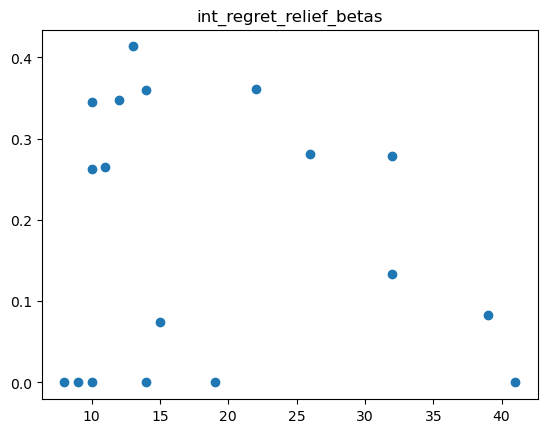

In [50]:
plt.scatter(subj_bdi,int_regret_relief_betas)
plt.title('int_regret_relief_betas')

dep_int_regret_relief_betas = regret_relief_fits[dep_subj].iloc[1]
nodep_int_regret_relief_betas = regret_relief_fits[nodep_subj].iloc[1]
stats.ttest_ind(dep_int_regret_relief_betas, nodep_int_regret_relief_betas, equal_var=False)

Ttest_indResult(statistic=-1.101973337104825, pvalue=0.28695502859040795)

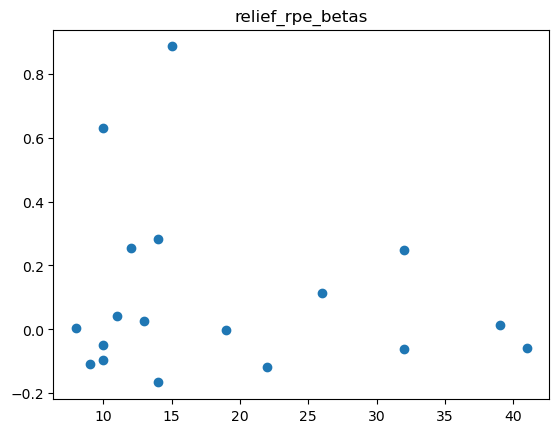

In [51]:
plt.scatter(subj_bdi,relief_rpe_betas)
plt.title('relief_rpe_betas')

dep_relief_rpe_betas = relief_rpe_fits[dep_subj].iloc[-1]
nodep_relief_rpe_betas = relief_rpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_relief_rpe_betas, nodep_relief_rpe_betas, equal_var=False)

Ttest_indResult(statistic=-1.7384644334576578, pvalue=0.11612606343941738)

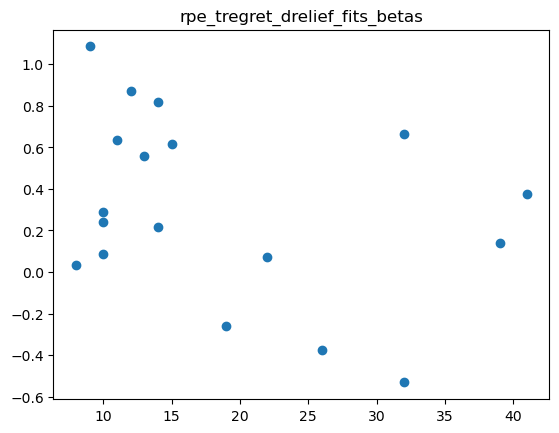

In [52]:
plt.scatter(subj_bdi,rpe_tregret_drelief_fits_betas)
plt.title('rpe_tregret_drelief_fits_betas')
dep_betas = rpe_tregret_drelief_fits[dep_subj].iloc[-3]
nodep_betas = rpe_tregret_drelief_fits[nodep_subj].iloc[-3]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=1.7632477497980363, pvalue=0.10854846134026364)

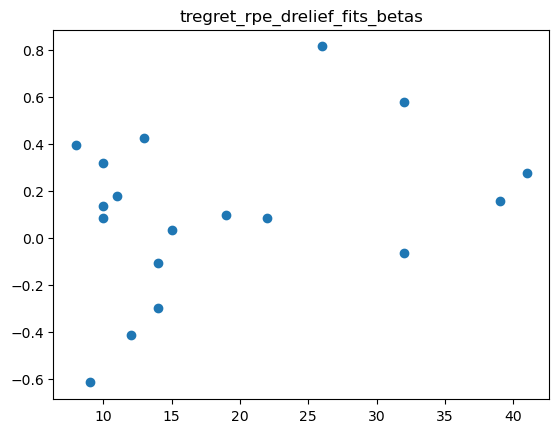

In [53]:
plt.scatter(subj_bdi,tregret_rpe_drelief_fits_betas)
plt.title('tregret_rpe_drelief_fits_betas')
dep_betas = rpe_tregret_drelief_fits[dep_subj].iloc[-2]
nodep_betas = rpe_tregret_drelief_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=0.10010691421334691, pvalue=0.9215789280427811)

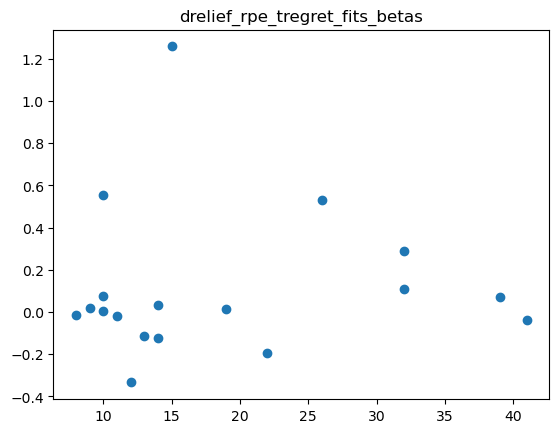

In [54]:
plt.scatter(subj_bdi,drelief_rpe_tregret_fits_betas)
plt.title('drelief_rpe_tregret_fits_betas')
dep_betas = rpe_tregret_drelief_fits[dep_subj].iloc[-1]
nodep_betas = rpe_tregret_drelief_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=-0.22717699341112066, pvalue=0.8231716007430996)

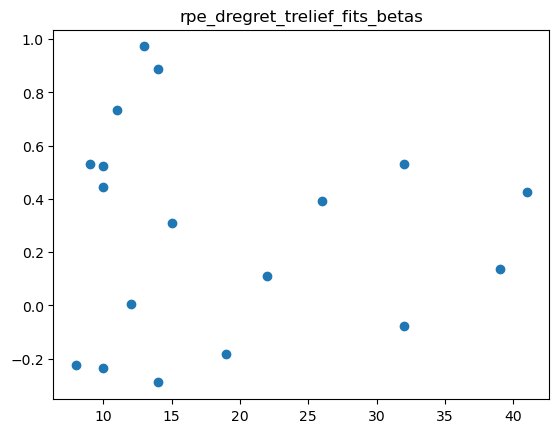

In [55]:
plt.scatter(subj_bdi,rpe_dregret_trelief_fits_betas)
plt.title('rpe_dregret_trelief_fits_betas')
dep_betas = rpe_dregret_trelief_fits[dep_subj].iloc[-3]
nodep_betas = rpe_dregret_trelief_fits[nodep_subj].iloc[-3]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=-1.5600260306475329, pvalue=0.13836620737426908)

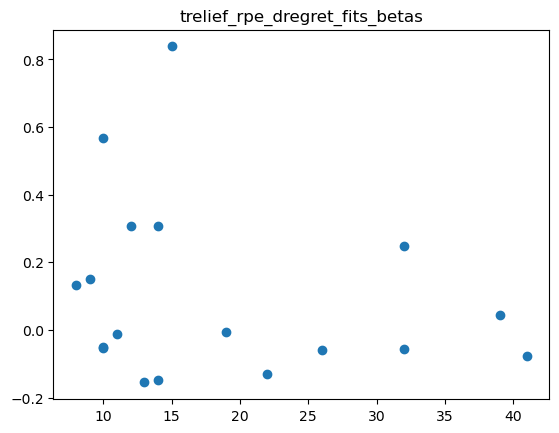

In [56]:
plt.scatter(subj_bdi,trelief_rpe_dregret_fits_betas)
plt.title('trelief_rpe_dregret_fits_betas')
dep_betas = rpe_dregret_trelief_fits[dep_subj].iloc[-1]
nodep_betas = rpe_dregret_trelief_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=1.8024322510787492, pvalue=0.09867943320511852)

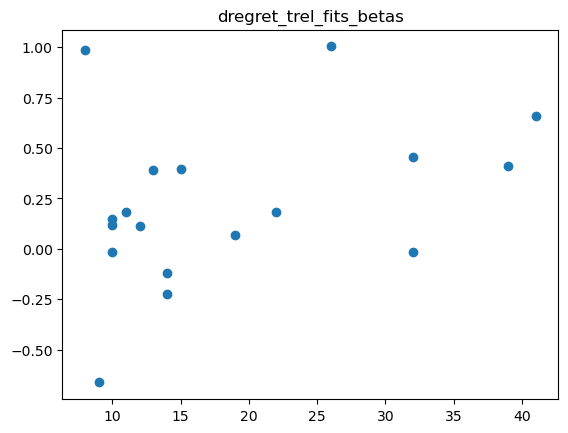

In [57]:
plt.scatter(subj_bdi,dregret_trel_fits_betas)
plt.title('dregret_trel_fits_betas')
dep_betas = dregret_trel_fits[dep_subj].iloc[-2]
nodep_betas = dregret_trel_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=-1.5601548690941605, pvalue=0.1383357790672808)

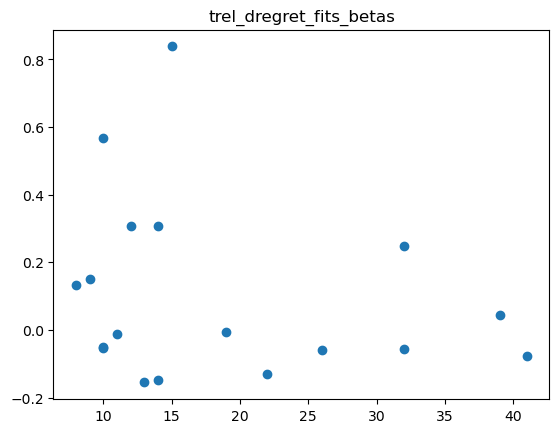

In [58]:
plt.scatter(subj_bdi,trel_dregret_fits_betas)
plt.title('trel_dregret_fits_betas')
dep_betas = dregret_trel_fits[dep_subj].iloc[-1]
nodep_betas = dregret_trel_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=1.7632499905149535, pvalue=0.10854832429494501)

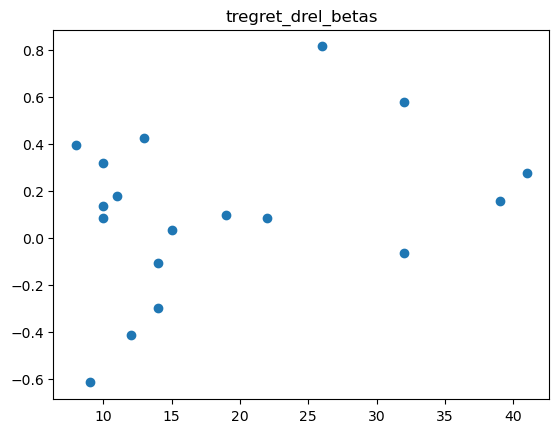

In [59]:
plt.scatter(subj_bdi,tregret_drel_betas)
plt.title('tregret_drel_betas')
dep_betas = tregret_drel_fits[dep_subj].iloc[-2]
nodep_betas = tregret_drel_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=0.10009546712329556, pvalue=0.9215878652434808)

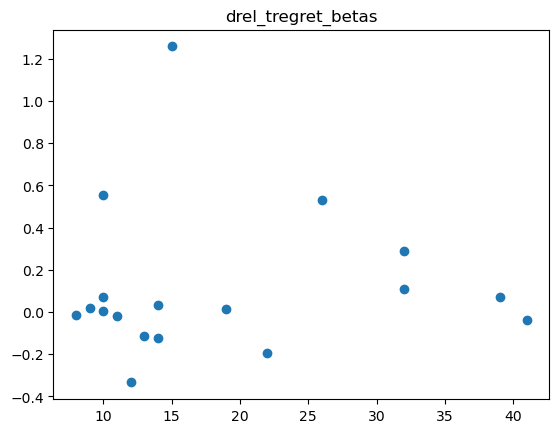

In [60]:
plt.scatter(subj_bdi,drel_tregret_betas)
plt.title('drel_tregret_betas')
dep_betas = tregret_drel_fits[dep_subj].iloc[-1]
nodep_betas = tregret_drel_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

Ttest_indResult(statistic=1.863668315335711, pvalue=0.08720970284787513)

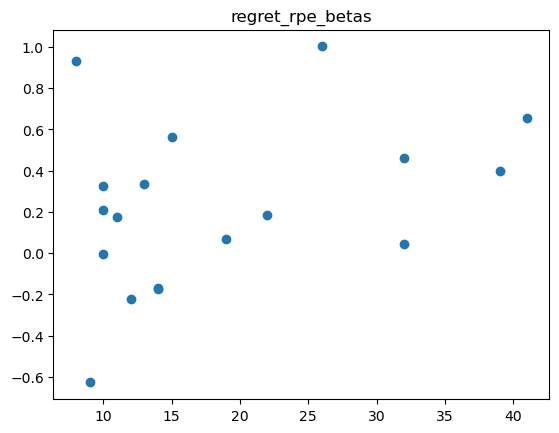

In [61]:
plt.scatter(subj_bdi,regret_rpe_betas)
plt.title('regret_rpe_betas')

dep_reg_rpe_betas = regret_rpe_fits[dep_subj].iloc[-1]
nodep_reg_rpe_betas = regret_rpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_reg_rpe_betas, nodep_reg_rpe_betas, equal_var=False)

Ttest_indResult(statistic=-1.101973337104825, pvalue=0.28695502859040795)

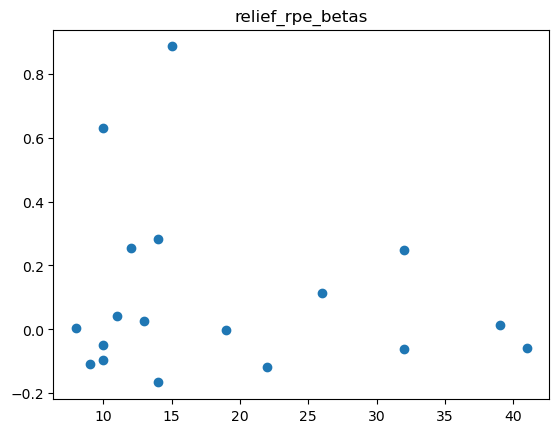

In [62]:
plt.scatter(subj_bdi,relief_rpe_betas)
plt.title('relief_rpe_betas')

dep_relief_rpe_betas = relief_rpe_fits[dep_subj].iloc[-1]
nodep_relief_rpe_betas = relief_rpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_relief_rpe_betas, nodep_relief_rpe_betas, equal_var=False)

In [63]:
plt.scatter(subj_bdi,cpe_betas)
plt.title('cpe_betas')
dep_cpe_betas = cpe_fits[dep_subj].iloc[-1]
nodep_cpe_betas = cpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_cpe_betas, nodep_cpe_betas, equal_var=False)

NameError: name 'cpe_betas' is not defined

In [48]:
plt.scatter(subj_bdi,rpe_betas)

plt.title('rpe_betas')

dep_rpe_betas = rpe_fits[dep_subj].iloc[-1]
nodep_rpe_betas = rpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_rpe_betas, nodep_rpe_betas, equal_var=False)

NameError: name 'rpe_betas' is not defined

Ttest_indResult(statistic=1.229287327547917, pvalue=0.2407627392090543)

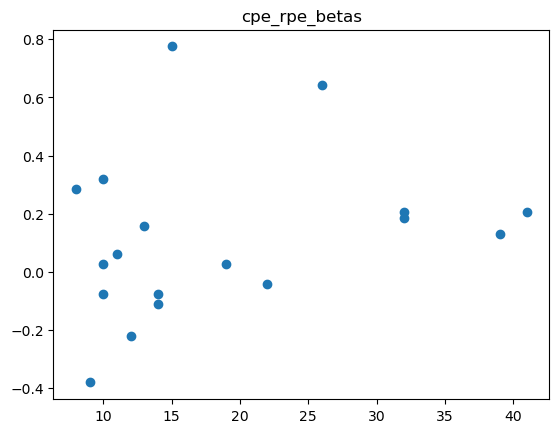

In [64]:
plt.scatter(subj_bdi,cpe_rpe_betas)

plt.title('cpe_rpe_betas')

dep_cpe_rpe_betas = cpe_rpe_fits[dep_subj].iloc[-1]
nodep_cpe_rpe_betas = cpe_rpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_cpe_rpe_betas, nodep_cpe_rpe_betas, equal_var=False)

Ttest_indResult(statistic=-1.6642939770249923, pvalue=0.11912890438728384)

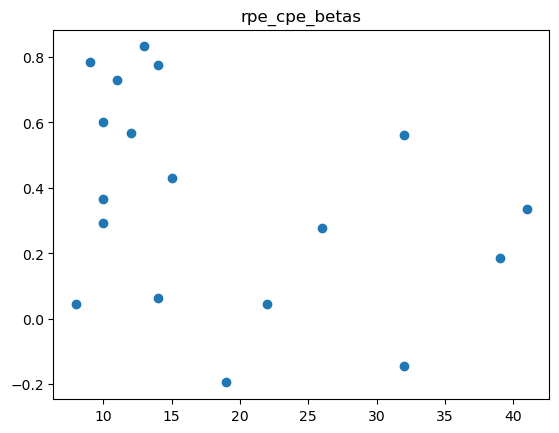

In [65]:
plt.scatter(subj_bdi,rpe_cpe_betas)

plt.title('rpe_cpe_betas')

dep_rpe_cpe_betas = cpe_rpe_fits[dep_subj].iloc[-2]
nodep_rpe_cpe_betas = cpe_rpe_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_rpe_cpe_betas, nodep_rpe_cpe_betas, equal_var=False)

In [66]:
plt.scatter(subj_bdi,regret_betas)

plt.title('regret_betas')

dep_regret_betas = regret_fits[dep_subj].iloc[-1]
nodep_regret_betas = regret_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_regret_betas, nodep_regret_betas, equal_var=False)

NameError: name 'regret_betas' is not defined

In [67]:
plt.scatter(subj_bdi,relief_betas)

plt.title('relief_betas')

dep_relief_betas = relief_fits[dep_subj].iloc[-1]
nodep_relief_betas = relief_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_relief_betas, nodep_relief_betas, equal_var=False)

NameError: name 'relief_betas' is not defined

Ttest_indResult(statistic=1.3036237753206472, pvalue=0.21367975071344583)

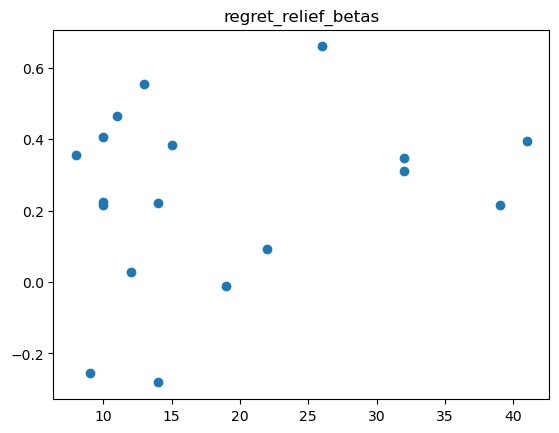

In [68]:
plt.scatter(subj_bdi,regret_relief_betas)

plt.title('regret_relief_betas')

dep_regret_relief_betas = regret_relief_fits[dep_subj].iloc[-2]
nodep_regret_relief_betas = regret_relief_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_regret_relief_betas, nodep_regret_relief_betas, equal_var=False)

Ttest_indResult(statistic=-1.4491548322750691, pvalue=0.16887453495421878)

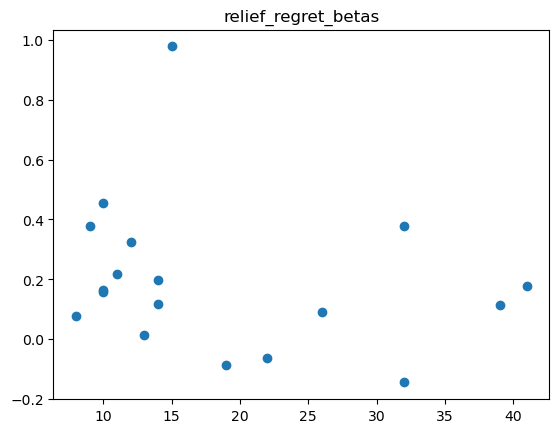

In [69]:
plt.scatter(subj_bdi,relief_regret_betas)
plt.title('relief_regret_betas')

dep_relief_regret_betas = regret_relief_fits[dep_subj].iloc[-1]
nodep_relief_regret_betas = regret_relief_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_relief_regret_betas, nodep_relief_regret_betas, equal_var=False)

Ttest_indResult(statistic=1.3733596686567373, pvalue=0.1943848228139754)

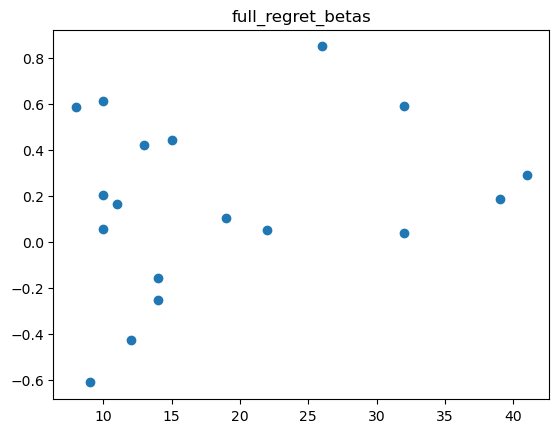

In [70]:
plt.scatter(subj_bdi,full_regret_betas)
plt.title('full_regret_betas')

dep_full_regret_betas = rpe_regret_relief_fits[dep_subj].iloc[-2]
nodep_full_regret_betas = rpe_regret_relief_fits[nodep_subj].iloc[-2]
stats.ttest_ind(dep_full_regret_betas, nodep_full_regret_betas, equal_var=False)

Ttest_indResult(statistic=-0.49866284001893674, pvalue=0.6250758778314838)

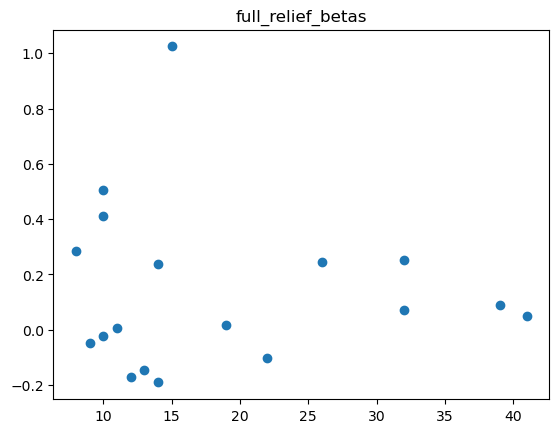

In [71]:
plt.scatter(subj_bdi,full_relief_betas)
plt.title('full_relief_betas')

dep_full_relief_betas = rpe_regret_relief_fits[dep_subj].iloc[-1]
nodep_full_relief_betas = rpe_regret_relief_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_full_relief_betas, nodep_full_relief_betas, equal_var=False)

Ttest_indResult(statistic=-1.0623693771621203, pvalue=0.30549224118781926)

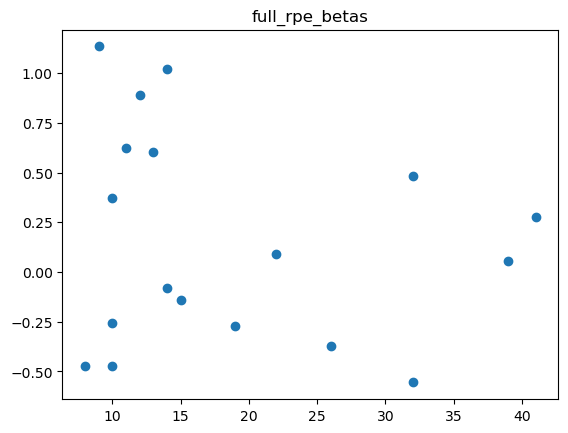

In [72]:
plt.scatter(subj_bdi,full_rpe_betas)
plt.title('full_rpe_betas')

dep_full_rpe_betas = rpe_regret_relief_fits[dep_subj].iloc[-3]
nodep_full_rpe_betas = rpe_regret_relief_fits[nodep_subj].iloc[-3]
stats.ttest_ind(dep_full_rpe_betas, nodep_full_rpe_betas, equal_var=False)

0.21367975071344583
0.16887453495421878


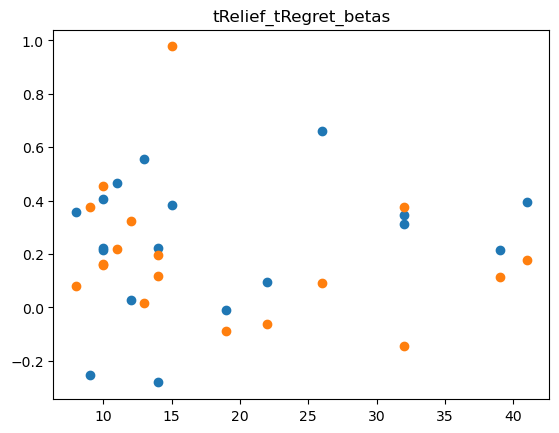

In [73]:
####### tRegret_tRelief
tRegret_tRelief_fits = models_results['tRegret_tRelief']['param_fits'] 
tRegret_tRelief_betas = tRegret_tRelief_fits.iloc[-2]
tRelief_tRegret_betas = tRegret_tRelief_fits.iloc[-1]

plt.scatter(subj_bdi,tRegret_tRelief_betas)
plt.title('tRegret_tRelief_fits')

dep_betas = tRegret_tRelief_fits[dep_subj].iloc[-2]
nodep_betas = tRegret_tRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,tRelief_tRegret_betas)
plt.title('tRelief_tRegret_betas')

dep_betas = tRegret_tRelief_fits[dep_subj].iloc[-1]
nodep_betas = tRegret_tRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

0.10854832429494501
0.9215878652434808


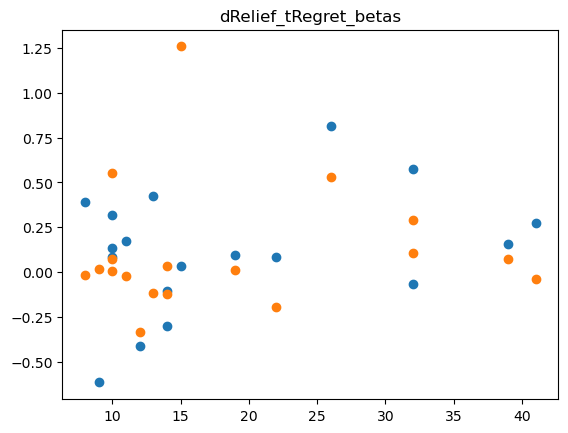

In [74]:
############ tRegret_dRelief
tRegret_dRelief_fits = models_results['tRegret_dRelief']['param_fits'] 
tRegret_dRelief_betas = tRegret_dRelief_fits.iloc[-2]
dRelief_tRegret_betas = tRegret_dRelief_fits.iloc[-1]

plt.scatter(subj_bdi,tRegret_dRelief_betas)
plt.title('tRegret_dRelief_betas')

dep_betas = tRegret_dRelief_fits[dep_subj].iloc[-2]
nodep_betas = tRegret_dRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,dRelief_tRegret_betas)
plt.title('dRelief_tRegret_betas')

dep_betas = tRegret_dRelief_fits[dep_subj].iloc[-1]
nodep_betas = tRegret_dRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

0.09867943320511852
0.1383357790672808


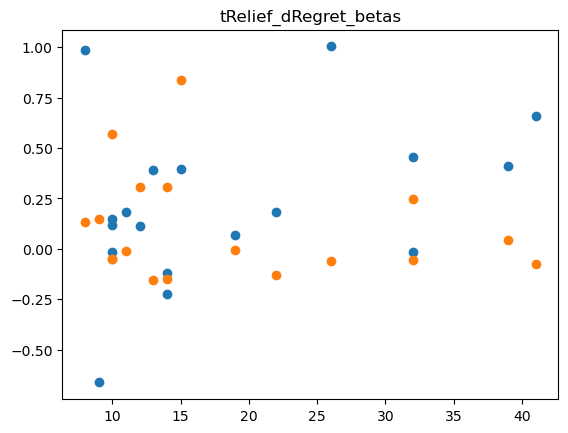

In [77]:
######### dRegret_tRelief

dRegret_tRelief_fits = models_results['dRegret_tRelief']['param_fits'] 
dRegret_tRelief_betas = dRegret_tRelief_fits.iloc[-2]
tRelief_dRegret_betas = dRegret_tRelief_fits.iloc[-1]

plt.scatter(subj_bdi,dRegret_tRelief_betas)
plt.title('dRegret_tRelief_betas')

dep_betas = dRegret_tRelief_fits[dep_subj].iloc[-2]
nodep_betas = dRegret_tRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)


plt.scatter(subj_bdi,tRelief_dRegret_betas)
plt.title('tRelief_dRegret_betas')

dep_betas = dRegret_tRelief_fits[dep_subj].iloc[-1]
nodep_betas = dRegret_tRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)


0.30549224118781926
0.1943848228139754
0.6250758778314838


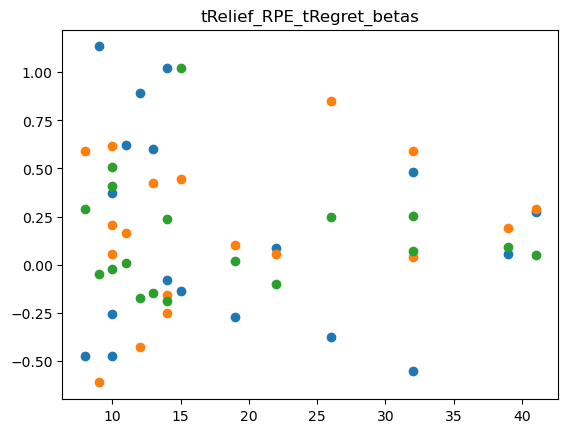

In [78]:
##########  RPE_tRegret_tRelief

RPE_tRegret_tRelief_fits = models_results['RPE_tRegret_tRelief']['param_fits'] 
RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-3]
tRegret_RPE_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-2]
tRelief_RPE_tRegret_betas = RPE_tRegret_tRelief_fits.iloc[-1]

plt.scatter(subj_bdi,RPE_tRegret_tRelief_betas)
plt.title('RPE_tRegret_tRelief_betas')

dep_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-3]
nodep_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-3]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,tRegret_RPE_tRelief_betas)
plt.title('tRegret_RPE_tRelief_betas')

dep_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-2]
nodep_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,tRelief_RPE_tRegret_betas)
plt.title('tRelief_RPE_tRegret_betas')

dep_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-1]
nodep_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)



0.11612606343941738
0.10854846134026364
0.9215789280427811


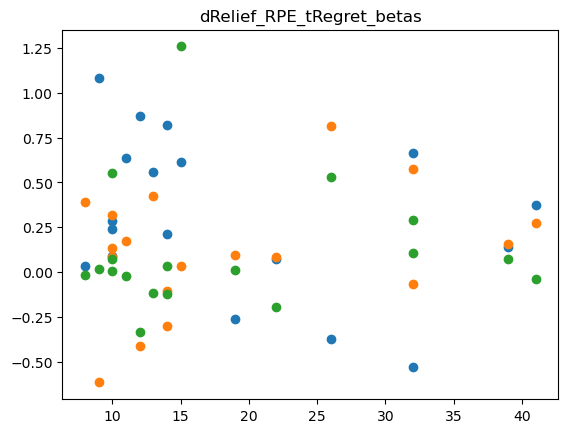

In [79]:
########### RPE_tRegret_dRelief

RPE_tRegret_dRelief_fits = models_results['RPE_tRegret_dRelief']['param_fits'] 
RPE_tRegret_dRelief_betas = RPE_tRegret_dRelief_fits.iloc[-3]
tRegret_RPE_dRelief_betas = RPE_tRegret_dRelief_fits.iloc[-2]
dRelief_RPE_tRegret_betas = RPE_tRegret_dRelief_fits.iloc[-1]

plt.scatter(subj_bdi,RPE_tRegret_dRelief_betas)
plt.title('RPE_tRegret_dRelief_betas')

dep_betas = RPE_tRegret_dRelief_fits[dep_subj].iloc[-3]
nodep_betas = RPE_tRegret_dRelief_fits[nodep_subj].iloc[-3]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)


plt.scatter(subj_bdi,tRegret_RPE_dRelief_betas)
plt.title('tRegret_RPE_dRelief_betas')

dep_betas = RPE_tRegret_dRelief_fits[dep_subj].iloc[-2]
nodep_betas = RPE_tRegret_dRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,dRelief_RPE_tRegret_betas)
plt.title('dRelief_RPE_tRegret_betas')

dep_betas = RPE_tRegret_dRelief_fits[dep_subj].iloc[-1]
nodep_betas = RPE_tRegret_dRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)



0.8231716007430996
0.09867147419962506
0.13836620737426908


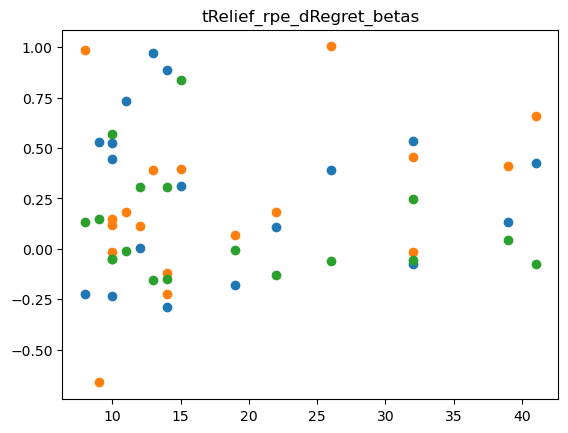

In [80]:
######## RPE_dRegret_tRelief

rpe_dregret_trelief_fits = models_results['RPE_dRegret_tRelief']['param_fits']

rpe_dregret_trelief_betas = rpe_dregret_trelief_fits.iloc[-3]
dRegret_rpe_tRelief_betas = rpe_dregret_trelief_fits.iloc[-2]
tRelief_rpe_dRegret_betas = rpe_dregret_trelief_fits.iloc[-1]

plt.scatter(subj_bdi,rpe_dregret_trelief_betas)
plt.title('rpe_dregret_trelief_betas')

dep_betas = rpe_dregret_trelief_fits[dep_subj].iloc[-3]
nodep_betas = rpe_dregret_trelief_fits[nodep_subj].iloc[-3]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)

plt.scatter(subj_bdi,dRegret_rpe_tRelief_betas)
plt.title('dRegret_rpe_tRelief_betas')

dep_betas = rpe_dregret_trelief_fits[dep_subj].iloc[-2]
nodep_betas = rpe_dregret_trelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)


plt.scatter(subj_bdi,tRelief_rpe_dRegret_betas)
plt.title('tRelief_rpe_dRegret_betas')

dep_betas = rpe_dregret_trelief_fits[dep_subj].iloc[-1]
nodep_betas = rpe_dregret_trelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_betas, nodep_betas, equal_var=False).pvalue)



Ttest_indResult(statistic=0.3587300952487393, pvalue=0.7276707252551933)

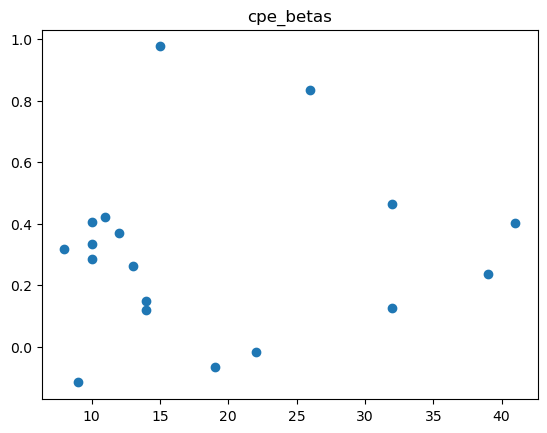

In [81]:
######### dcpe 
cpe_fits = models_results['dCPE']['param_fits']

cpe_betas = cpe_fits.iloc[-1]

plt.scatter(subj_bdi,cpe_betas)
plt.title('cpe_betas')

dep_betas = cpe_fits[dep_subj].iloc[-1]
nodep_betas = cpe_fits[nodep_subj].iloc[-1]
stats.ttest_ind(dep_betas, nodep_betas, equal_var=False)

# Model Figures

winning model = rpe treg,trel

## Regressor Weights plots

In [82]:
import statistics

In [100]:
# final_model_list  = ['RPE','dCPE','RPE_dCPE','dRegret','dRelief','tRelief','dRegret_dRelief','dRegret_tRelief','RPE_dRegret_tRelief','RPE_dRegret_dRelief'] confirmed dRelief here

final_model_list  = ['RPE','dCPE','RPE_dCPE','dRegret','dRelief','dRegret_dRelief','RPE_dRegret_dRelief']

In [147]:
subj_bdi[3]

41

In [150]:
depressed

False

In [154]:
#list(zip(subj_ids,subj_bdi))
best_depressed_model = []
best_nondepressed_model = []
best_depressed_bic = []
best_nondepressed_bic = []
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_model_bic = []
    if subj_bdi[ix] >= 20:
        depressed = True
    else:
        depressed = False
    for model in final_model_list:
        bic = models_data[model]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
    if depressed:
        best_depressed_bic.append(best_bic)
        best_depressed_model.append(best_model_bic)
    else:
        best_nondepressed_bic.append(best_bic)
        best_nondepressed_model.append(best_model_bic)
    print('best model bic for ',s,'is',best_model_bic,best_bic)
print(best_depressed_model)
print(best_nondepressed_model)




best model bic for  DA8 is dRelief 33.88568826737055
best model bic for  DA9 is dRelief 34.403153297353676
best model bic for  DA10 is dRegret 34.35329062042694
best model bic for  DA11 is dRegret 34.568725938776296
best model bic for  DA023 is dRegret 34.544130731913405
best model bic for  MS002 is RPE 34.51450794552325
best model bic for  MS003 is dRegret 34.5689793111034
best model bic for  MS016 is dRelief 34.63011256628067
best model bic for  MS017 is dRelief 33.83771673230641
best model bic for  MS019 is dRelief 34.670803927386345
best model bic for  MS022 is dRegret 34.4749898833474
best model bic for  MS025 is dRelief 34.24183666534904
best model bic for  MS026 is dRegret 34.10241453530827
best model bic for  MS027 is dRelief 34.47516848945498
best model bic for  MS029 is dRelief 34.43208762501166
best model bic for  MS030 is RPE 34.394887544744115
best model bic for  MS033 is dRelief 34.21352808073026
best model bic for  MS035 is dRelief 33.62763059295916
['dRelief', 'dRegret'

In [157]:
list(np.unique(best_depressed_model))


['dRegret', 'dRelief']

In [158]:
list(np.unique(best_nondepressed_model))

['RPE', 'dRegret', 'dRelief']

In [160]:
best_depressed

[('dRelief', 34.403153297353676),
 ('dRegret', 34.568725938776296),
 ('dRelief', 33.83771673230641),
 ('dRelief', 34.47516848945498),
 ('dRelief', 34.43208762501166),
 ('dRelief', 34.21352808073026)]

In [167]:
b

34.21352808073026

In [168]:
best_depressed = list(zip(best_depressed_model,best_depressed_bic))
depressed_models = list(np.unique(best_depressed_model))

for model in depressed_models:
    model_bic = []
    for m,b in best_depressed:
        if m == model:
            model_bic.append(b)
    print(model,np.mean(model_bic))


dRegret 34.568725938776296
dRelief 34.2723308449714


In [169]:
best_nondepressed = list(zip(best_nondepressed_model,best_nondepressed_bic))
nondepressed_models = list(np.unique(best_nondepressed_model))

for model in nondepressed_models:
    model_bic = []
    for m,b in best_nondepressed:
        if m == model:
            model_bic.append(b)
    print(model,np.mean(model_bic))

RPE 34.454697745133686
dRegret 34.40876101641989
dRelief 34.21121440386915


In [146]:
list(zip(subj_ids,subj_bdi))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS002', 14),
 ('MS003', 8),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39),
 ('MS035', 15)]

In [102]:
min_bic = np.inf
best_model = []
for model in final_model_list:
    bic_mean = np.mean(np.array(list(models_data[model]['bics2'].values())))
    if bic_mean<min_bic:
        min_bic = bic_mean
        best_model = model
    print(model,'BIC2 mean',bic_mean)
print('the best model is ',best_model)



RPE BIC2 mean 34.491828117897185
dCPE BIC2 mean 34.448224285781514
RPE_dCPE BIC2 mean 41.247136362840116
dRegret BIC2 mean 34.44382247270112
dRelief BIC2 mean 34.369001639670934
dRegret_dRelief BIC2 mean 41.221409238990184
RPE_dRegret_dRelief BIC2 mean 48.012670440868874
the best model is  dRelief


In [103]:
r2_dict = {}

for subj_id in subj_ids:
    observed_mood = model_input.zscore_rate[model_input.subj_id==subj_id]
    subj_r2_scores = []
    for model in final_model_list:
        est_mood = models_results[model]['mood_est'][subj_id]
        rsq = r2_score(observed_mood,est_mood)
        subj_r2_scores.append(rsq)
    r2_dict[subj_id] = list(zip(subj_r2_scores,final_model_list))



for subj_id in subj_ids:
    best_rsq = -np.inf
    best_model_rsq = []
    for rsq,model in (r2_dict[subj_id]):
        if rsq > best_rsq:
            best_rsq = rsq
            best_model_rsq = model
    print('best model rsq for ',subj_id,'is',best_model_rsq,best_rsq)


max_rsq = -np.inf
best_model = []

for ix,model in enumerate(final_model_list):
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    model_rsq_median = statistics.median(rsq_list)
    model_rsq_sum = np.sum(rsq_list)
    print(model, model_rsq,model_rsq_median,model_rsq_sum)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model,max_rsq)


best model rsq for  DA8 is RPE_dRegret_dRelief 0.34820112610082055
best model rsq for  DA9 is RPE_dRegret_dRelief 0.5801586902332023
best model rsq for  DA10 is RPE_dRegret_dRelief 0.46907617984341754
best model rsq for  DA11 is RPE_dRegret_dRelief 0.2318792245394471
best model rsq for  DA023 is dRegret_dRelief 0.059760844081214404
best model rsq for  MS002 is RPE_dRegret_dRelief 0.20923752636304416
best model rsq for  MS003 is RPE_dRegret_dRelief 0.17227812610717286
best model rsq for  MS016 is RPE_dRegret_dRelief 0.22682847316030985
best model rsq for  MS017 is RPE_dRegret_dRelief 0.40095861979378267
best model rsq for  MS019 is RPE_dRegret_dRelief 0.16837420597974062
best model rsq for  MS022 is RPE_dRegret_dRelief 0.18642007626538415
best model rsq for  MS025 is RPE_dRegret_dRelief 0.474330206317789
best model rsq for  MS026 is RPE_dRegret_dRelief 0.20112735414262595
best model rsq for  MS027 is RPE_dRegret_dRelief 0.11782954322758177
best model rsq for  MS029 is RPE_dRegret_dRelie

In [104]:

RPE_tRegret_tRelief_fits = models_results['RPE_dRegret_dRelief']['param_fits'] 
cr_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-5]
ev_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-4]
RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-3]
tRegret_RPE_tRelief_betas = RPE_tRegret_tRelief_fits.iloc[-2]
tRelief_RPE_tRegret_betas = RPE_tRegret_tRelief_fits.iloc[-1]

dep_cr_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-5]
nodep_cr_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-5]
print(stats.ttest_ind(dep_cr_RPE_tRegret_tRelief_betas, nodep_cr_RPE_tRegret_tRelief_betas, equal_var=False).pvalue)

dep_ev_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-4]
nodep_ev_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-4]
print(stats.ttest_ind(dep_ev_RPE_tRegret_tRelief_betas, nodep_ev_RPE_tRegret_tRelief_betas, equal_var=False).pvalue)

# plt.scatter(subj_bdi,RPE_tRegret_tRelief_betas)
# plt.title('RPE_tRegret_tRelief_betas')

dep_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-3]
nodep_RPE_tRegret_tRelief_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-3]
print(stats.ttest_ind(dep_RPE_tRegret_tRelief_betas, nodep_RPE_tRegret_tRelief_betas, equal_var=False).pvalue)

# plt.scatter(subj_bdi,tRegret_RPE_tRelief_betas)
# plt.title('tRegret_RPE_tRelief_betas')

dep_tRegret_RPE_tRelief_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-2]
nodep_tRegret_RPE_tRelief_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-2]
print(stats.ttest_ind(dep_tRegret_RPE_tRelief_betas, nodep_tRegret_RPE_tRelief_betas, equal_var=False).pvalue)

# plt.scatter(subj_bdi,tRelief_RPE_tRegret_betas)
# plt.title('tRelief_RPE_tRegret_betas')

dep_tRelief_RPE_tRegret_betas = RPE_tRegret_tRelief_fits[dep_subj].iloc[-1]
nodep_tRelief_RPE_tRegret_betas = RPE_tRegret_tRelief_fits[nodep_subj].iloc[-1]
print(stats.ttest_ind(dep_tRelief_RPE_tRegret_betas, nodep_tRelief_RPE_tRegret_betas, equal_var=False).pvalue)

0.6168384680853545
0.28954662155812816
0.24220921231841677
0.07313922427600673
0.6620661889111132


In [105]:
depression_weights_plot = pd.DataFrame(data={'Certain Reward':cr_RPE_tRegret_tRelief_betas,'Expected Value':ev_RPE_tRegret_tRelief_betas,'RPE':RPE_tRegret_tRelief_betas,'Regret':tRegret_RPE_tRelief_betas,'Relief':tRelief_RPE_tRegret_betas})
#depression_weights_plot = pd.DataFrame(columns=[{'Certain Reward','Expected Value','RPE','Regret','Relief':}])

In [106]:
depression_weights_plot

,Certain Reward,Expected Value,RPE,Regret,Relief
DA8,-0.616209,0.641702,0.913141,0.374737,-0.100627
DA9,-0.388527,0.895104,0.633265,-0.098373,0.301263
DA10,0.956663,0.433326,0.733149,0.186729,-0.017233
DA11,0.772910,0.608535,0.393843,0.678085,-0.116916
DA023,0.286214,0.502503,0.056294,-0.170576,-0.001337
MS002,-0.271316,0.810045,0.780993,-0.136679,-0.088300
MS003,0.464863,0.126831,-0.021092,0.927585,-0.030223
MS016,-0.007005,0.315622,0.364620,-0.001430,0.043972
MS017,1.094775,-0.125416,0.267208,0.952768,0.295217
MS019,0.883584,0.235494,0.590779,-0.350191,-0.171109


In [107]:
bdi_split = []

for subj_id in depression_weights_plot.index:
    if subj_id in dep_subj:
        bdi_split.append('High BDI')
    else:
        bdi_split.append('Low BDI')

depression_weights_plot['Depression'] = bdi_split


In [108]:
depression_weights_plot

,Certain Reward,Expected Value,RPE,Regret,Relief,Depression
DA8,-0.616209,0.641702,0.913141,0.374737,-0.100627,Low BDI
DA9,-0.388527,0.895104,0.633265,-0.098373,0.301263,High BDI
DA10,0.956663,0.433326,0.733149,0.186729,-0.017233,Low BDI
DA11,0.772910,0.608535,0.393843,0.678085,-0.116916,High BDI
DA023,0.286214,0.502503,0.056294,-0.170576,-0.001337,Low BDI
MS002,-0.271316,0.810045,0.780993,-0.136679,-0.088300,Low BDI
MS003,0.464863,0.126831,-0.021092,0.927585,-0.030223,Low BDI
MS016,-0.007005,0.315622,0.364620,-0.001430,0.043972,Low BDI
MS017,1.094775,-0.125416,0.267208,0.952768,0.295217,High BDI
MS019,0.883584,0.235494,0.590779,-0.350191,-0.171109,Low BDI


In [109]:
sns.color_palette("crest",n_colors=10).as_hex()

['#8bc191',
 '#72b490',
 '#5ca890',
 '#4a9a8f',
 '#3b8c8e',
 '#2c7e8c',
 '#20718b',
 '#1d6188',
 '#225282',
 '#29427a']

In [110]:
color_list = sns.color_palette("crest",n_colors=10).as_hex()

In [111]:
color_list

['#8bc191',
 '#72b490',
 '#5ca890',
 '#4a9a8f',
 '#3b8c8e',
 '#2c7e8c',
 '#20718b',
 '#1d6188',
 '#225282',
 '#29427a']

Text(0.5, 0.93, 'Altered Emotional Sensitivity to \n Reward Signals in Depression')

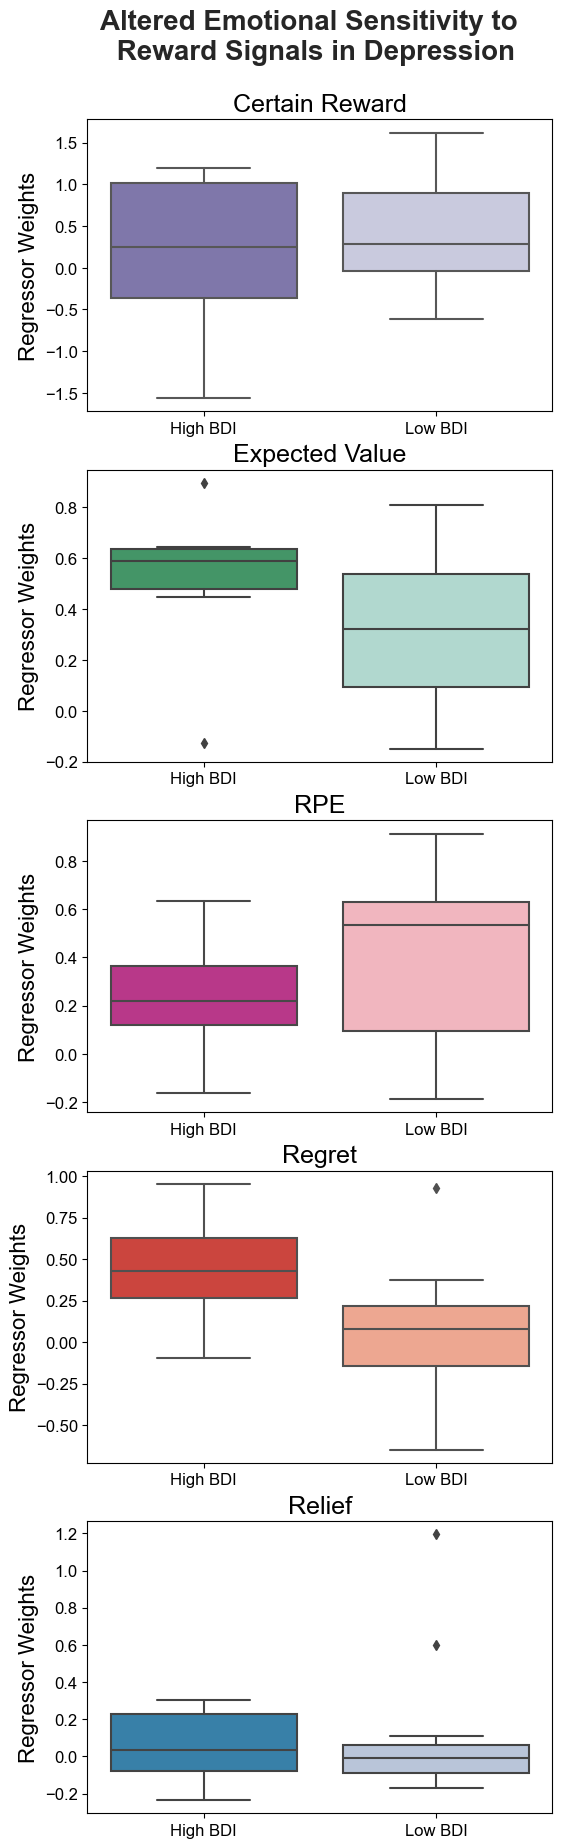

In [112]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(6,22))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='Certain Reward',order=["High BDI", "Low BDI"],palette='Purples_r')
sns.boxplot(ax=ax2,data=depression_weights_plot, x='Depression',y='Expected Value',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax3,data=depression_weights_plot, x='Depression',y='RPE',order=["High BDI", "Low BDI"],palette='RdPu_r')
sns.boxplot(ax=ax4,data=depression_weights_plot, x='Depression',y='Regret',order=["High BDI", "Low BDI"],palette='Reds_r')
sns.boxplot(ax=ax5,data=depression_weights_plot, x='Depression',y='Relief',order=["High BDI", "Low BDI"],palette='PuBu_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Certain Reward',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Expected Value',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax3.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('RPE',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax4.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
ax4.set_title('Regret',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax5.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax5.set_xlabel(None)
ax5.tick_params(labelsize=12)
ax5.set_title('Relief',weight='medium',fontsize=18)

#fig.supylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
fig.suptitle('Altered Emotional Sensitivity to \n Reward Signals in Depression',y=0.93,weight='semibold',fontsize=20)

# plt.savefig(f'{proj_dir}figs/swb_model_figs/weights_bdi_plot.png', dpi=500, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 


## BIC model comparison fig

In [113]:
min_bic = np.inf
best_model = []
for model in final_model_list:
    bic_mean = np.mean(np.array(list(models_data[model]['bics2'].values())))
    if bic_mean<min_bic:
        min_bic = bic_mean
        best_model = model
    print(model,'BIC2 mean',bic_mean)
print('the best model is ',best_model)

min_bic = np.inf
best_model = []
for model in final_model_list:
    bic_sum = np.sum(np.array(list(models_data[model]['bics2'].values())))
    if bic_sum<min_bic:
        min_bic = bic_sum
        best_model = model
    print(model,'BIC2 sum',bic_sum)
print('the best model is ',best_model)
          

RPE BIC2 mean 34.491828117897185
dCPE BIC2 mean 34.448224285781514
RPE_dCPE BIC2 mean 41.247136362840116
dRegret BIC2 mean 34.44382247270112
dRelief BIC2 mean 34.369001639670934
dRegret_dRelief BIC2 mean 41.221409238990184
RPE_dRegret_dRelief BIC2 mean 48.012670440868874
the best model is  dRelief
RPE BIC2 sum 620.8529061221493
dCPE BIC2 sum 620.0680371440673
RPE_dCPE BIC2 sum 742.4484545311221
dRegret BIC2 sum 619.9888045086202
dRelief BIC2 sum 618.6420295140769
dRegret_dRelief BIC2 sum 741.9853663018233
RPE_dRegret_dRelief BIC2 sum 864.2280679356397
the best model is  dRelief


In [114]:
final_model_list  = ['RPE','dCPE','RPE_dCPE','dRegret','dRelief','dRegret_dRelief','RPE_dRegret_dRelief']

In [115]:
subj_bdi

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 10, 9, 22, 32, 19, 39, 15]

In [116]:
final_model_list  = ['RPE','dCPE','RPE_dCPE','dRegret','dRelief','dRegret_dRelief','RPE_dRegret_dRelief']

rpe_bic = np.array(list(models_data['RPE']['bics2'].values()))
cpe_bic = np.array(list(models_data['dCPE']['bics2'].values()))
rpe_cpe_bic = np.array(list(models_data['RPE_dCPE']['bics2'].values()))
regret_bic = np.array(list(models_data['tRegret']['bics2'].values()))
relief_bic = np.array(list(models_data['tRelief']['bics2'].values()))
rpe_regret_relief_bic = np.array(list(models_data['RPE_tRegret_tRelief']['bics2'].values()))

In [117]:
bar_data = pd.DataFrame(columns=['RPE','CPE','RPE+CPE','Regret','Relief','RPE+Regret+Relief'])
bar_data['RPE'] = rpe_bic
bar_data['CPE'] = cpe_bic
bar_data['RPE+CPE'] = rpe_cpe_bic
bar_data['Regret'] = regret_bic
bar_data['Relief'] = relief_bic
bar_data['RPE+Regret+Relief'] = rpe_regret_relief_bic

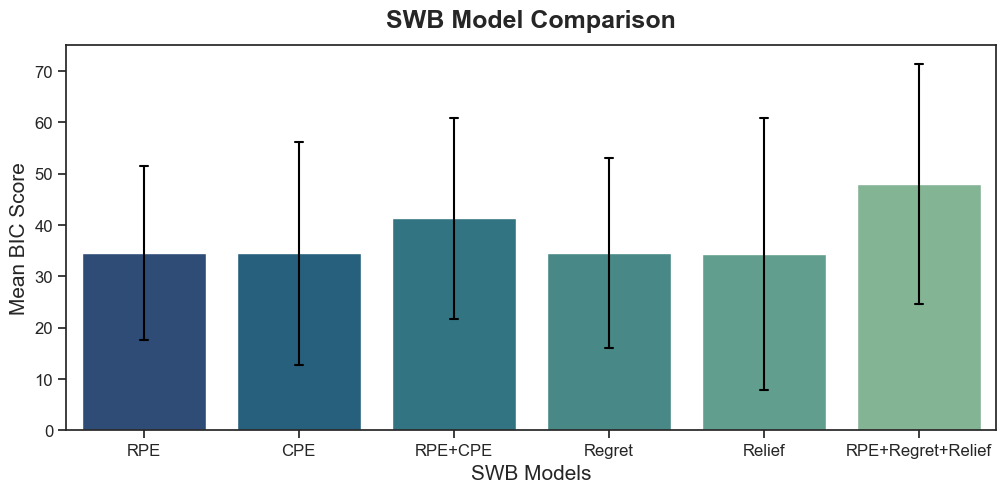

In [118]:
fig,ax = plt.subplots(figsize=(12,5))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data,order=['RPE','CPE','RPE+CPE','Regret','Relief','RPE+Regret+Relief'],estimator='mean',errorbar=('sd', 95),saturation=0.8,palette='crest_r',capsize=0.05,errcolor='black',errwidth=1.5)
ax.set_title('SWB Model Comparison',weight='semibold',fontsize=18,y=1.025)
ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)


# plt.savefig(f'{proj_dir}figs/swb_model_figs/bic_mean_comparison_cooltone.png', dpi=500, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

## Mood Estimation fit

In [120]:
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
#dictionaries for data storage
rate_total = []
rate_dep_total = []
rate_nodep_total = []

## Load behavioral data & save to group dict
for subj_id in subj_ids:
    mood_df = pd.read_csv(f'{behav_dir}{subj_id}_rate_data')
    mood_df = mood_df[mood_df.columns.drop(list(mood_df.filter(regex='Unnamed')))]
    rate_total.append(np.array(mood_df['zscore_mood']))
    if subj_id in dep_subj:
        rate_dep_total.append(np.array(mood_df['zscore_mood']))
    else:
        rate_nodep_total.append(np.array(mood_df['zscore_mood']))

In [121]:
rate_plot = list(zip(*rate_total))
rate_means = [np.mean(rates) for rates in rate_plot]

In [122]:
mood_est = list(models_results['dCPE']['mood_est'].mean(axis=1))

In [123]:
print(r2_score(rate_means[1:],mood_est))

0.0848399627013261


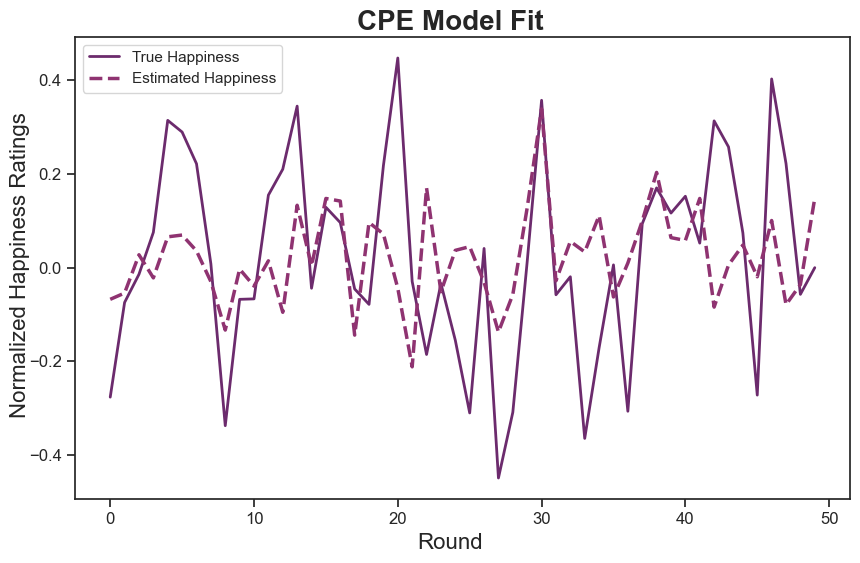

In [125]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
sns.lineplot(x=np.arange(0,50), y=rate_means[1:],label='True Happiness',linewidth=2)
sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=20,y=0.925)
fig.supxlabel('Round',font='Arial',fontsize=16,y=0.02)
fig.supylabel('Normalized Happiness Ratings',font='Arial',fontsize=16,x=0.06)
ax.tick_params(labelsize=12)
# ax.set_ylim(-1,1)

# plt.savefig(f'{proj_dir}figs/swb_model_figs/cpe_model_fit.png', dpi=500, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None)   

In [949]:

# rate_plot = list(zip(*rate_dep_total))
# rate_means = [np.mean(rates) for rates in rate_plot]

# mood_est = list(models_results['dCPE']['mood_est'][dep_subj].mean(axis=1))
# print(r2_score(rate_means[1:],mood_est))

# fig,ax = plt.subplots(figsize=(10,6))
# #sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
# sns.lineplot(x=np.arange(0,50), y=rate_means[1:],label='True Happiness',linewidth=2)
# sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
# fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=20,y=0.95)
# fig.supxlabel('Round',font='Arial',fontsize=16,y=0.01)
# fig.supylabel('Normalized Happiness Ratings',font='Arial',fontsize=16,x=0.045)
# ax.tick_params(labelsize=12)
# ax.set_ylim(-1,1)



In [950]:
# rate_plot = list(zip(*rate_nodep_total))
# rate_means = [np.mean(rates) for rates in rate_plot]

# mood_est = list(models_results['dCPE']['mood_est'][nodep_subj].mean(axis=1))
# print(r2_score(rate_means[1:],mood_est))

# fig,ax = plt.subplots(figsize=(10,6))
# #sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
# sns.lineplot(x=np.arange(0,50), y=rate_means[1:],label='True Happiness',linewidth=2)
# sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
# fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=20,y=0.95)
# fig.supxlabel('Round',font='Arial',fontsize=16,y=0.01)
# fig.supylabel('Normalized Happiness Ratings',font='Arial',fontsize=16,x=0.045)
# ax.tick_params(labelsize=12)
# ax.set_ylim(-1,1)

### lambda info fig

In [126]:
lams = models_results['dCPE']['param_fits'].iloc[0]
b_cr = models_results['dCPE']['param_fits'].iloc[2]
b_ev = models_results['dCPE']['param_fits'].iloc[3]
b_reg = models_results['dCPE']['param_fits'].iloc[4]

l = np.mean(np.array(lams))
cr = np.mean(np.array(b_cr))
ev = np.mean(np.array(b_ev))
reg = np.mean(np.array(b_reg))
import itertools

weights_plot_df = pd.DataFrame(columns=['trial','Regressor','Weight_Estimate'])
weights_plot_df['trial'] = ['t1','t2','t3']*(len(models_results['dCPE']['param_fits'])-2)
weights_plot_df['Regressor'] = list(itertools.chain.from_iterable([['Certain Reward']*3,['Expected Value']*3,['Regret']*3]))



#cr
cr_t1 = cr
cr_t2 = cr*l
cr_t3 = cr*(l**2)

#ev
ev_t1 = ev
ev_t2 = ev*l
ev_t3 = ev*(l**2)

#reg
reg_t1 = reg
reg_t2 = reg*l
reg_t3 = reg*(l**2)


weights_plot_df['Weight_Estimate'] = [cr_t1,cr_t2,cr_t3,ev_t1,ev_t2,ev_t3,reg_t1,reg_t2,reg_t3]


Text(-0.01, 0.5, 'Regressor Weight')

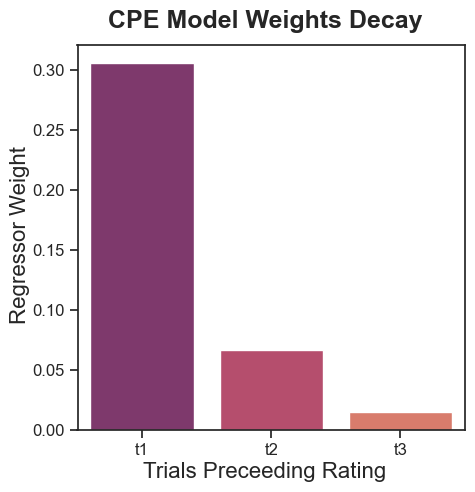

In [127]:
#weights plot
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='flare_r',saturation=0.8)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)

fig.suptitle('CPE Model Weights Decay',weight='semibold',fontsize=18, y=0.95)
fig.supxlabel('Trials Preceeding Rating',weight='medium',fontsize=16,y=0.005)
fig.supylabel('Regressor Weight',weight='medium',fontsize=16,x=-0.01)

# plt.savefig(f'{proj_dir}figs/swb_model_figs/cpe_weight_decay.png', dpi=500, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None)   


# Model Free Behav

In [128]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{swb_dir}behavior_analysis/behavior_preprocessed/'
proj_dir = f'{swb_dir}presentations/cpc_2023_poster/'

In [111]:
# subj_list = pd.read_excel(f'{proj_dir}subjects.xlsx', sheet_name='patient_info', usecols=[0])
# subj_ids = list(subj_list.PatientID)

In [129]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

In [130]:
subj_ids

['DA8',
 'DA9',
 'DA10',
 'DA11',
 'DA023',
 'MS002',
 'MS003',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS030',
 'MS033',
 'MS035']

In [131]:
#dictionaries for data storage
mood_dict = {f'{x}': [] for x in subj_ids}

## Load behavioral data & save to group dict
for subj_id in subj_ids:
    mood_df = pd.read_csv(f'{behav_dir}{subj_id}_rate_data')
    mood_df = mood_df[mood_df.columns.drop(list(mood_df.filter(regex='Unnamed')))]
    mood_dict[subj_id] = mood_df
    ## rate data

### Mood by BDI Fig

In [118]:
subj_bdi

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 10, 9, 22, 32, 19, 39]

In [132]:
dep_subj = []
nodep_subj = []

for s,b in list(zip(subj_ids,subj_bdi)):
    if b >= 20:
        dep_subj.append(s)
    else:
        nodep_subj.append(s)

In [133]:
moods = []
bdi_split = []

for subj_id in subj_ids:
    mood = mood_dict[subj_id]
    moods.extend(list(mood.zscore_mood))
    if subj_id in dep_subj:
        bdi_labels = ['High BDI']*len(mood)
    else:
        bdi_labels = ['Low BDI']*len(mood)
    bdi_split.extend(bdi_labels)




In [134]:
mood_plot = pd.DataFrame(columns=['Mood Rating','Depression'])
mood_plot['Mood Rating'] = moods
mood_plot['Depression'] = bdi_split

(<Axes: >, [<statannot.StatResult.StatResult at 0x132ebd4d0>])

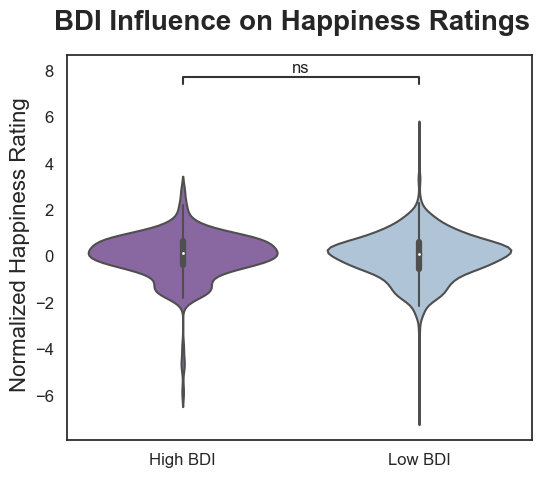

In [135]:
fig,(ax1) = plt.subplots(1,1,figsize=(6,5)) 
sns.set_theme(style="ticks",font='Arial') 
sns.violinplot(data=mood_plot,ax=ax1,x='Depression',y='Mood Rating',palette='BuPu_r',scale='area',order=["High BDI", "Low BDI"])


ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)

fig.supylabel('Normalized Happiness Rating',x=0.03,weight='medium',fontsize=16)
fig.suptitle('BDI Influence on Happiness Ratings',y=0.97,weight='semibold',fontsize=20)

mood_results = add_stat_annotation(ax1, data=mood_plot, x='Depression',y='Mood Rating', 
                                    box_pairs=[("High BDI", "Low BDI")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=0,line_offset_to_box=0.15)

mood_results

# plt.savefig(f'{proj_dir}figs/swb_model_free_figs/bdi_mood_split.png', dpi=300, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None)   

### Gamble Behavior

In [136]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/scripts/python_pipeline/')
import SWB_behav_utils

In [124]:
len(behav_df[0:75])

NameError: name 'behav_df' is not defined

In [137]:
#loading all subj task and rate df, computing norm gamble choices, saving information for plots

behav_dict = {f'{x}': [] for x in subj_ids}
master_gamble = {}

for subj_id in subj_ids:
    behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
    behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
    behav_dict[subj_id] = behav_df
    loss,mix,gain = SWB_behav_utils.norm_gamble_choices(behav_df)
    master_gamble[subj_id] = {'loss':loss,
                              'mix': mix,
                              'gain': gain}



In [138]:
gamble_plot = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

for subj_id in subj_ids:
    data = master_gamble[subj_id]
    df={}
    df['loss_x'] = data['loss']['loss_x_axis']
    df['loss_y'] = data['loss']['loss_choice_props']

    df['mix_x'] = data['mix']['mix_x_axis']
    df['mix_y'] =  data['mix']['mix_choice_props']

    df['gain_x'] = data['gain']['gain_x_axis']
    df['gain_y'] = data['gain']['gain_choice_props']

    gamble_plot = pd.concat([gamble_plot,pd.DataFrame(df)])

gamble_plot = gamble_plot.dropna(axis=0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.03, 'Frequency of Gamble Choices Increases with Expected Value')

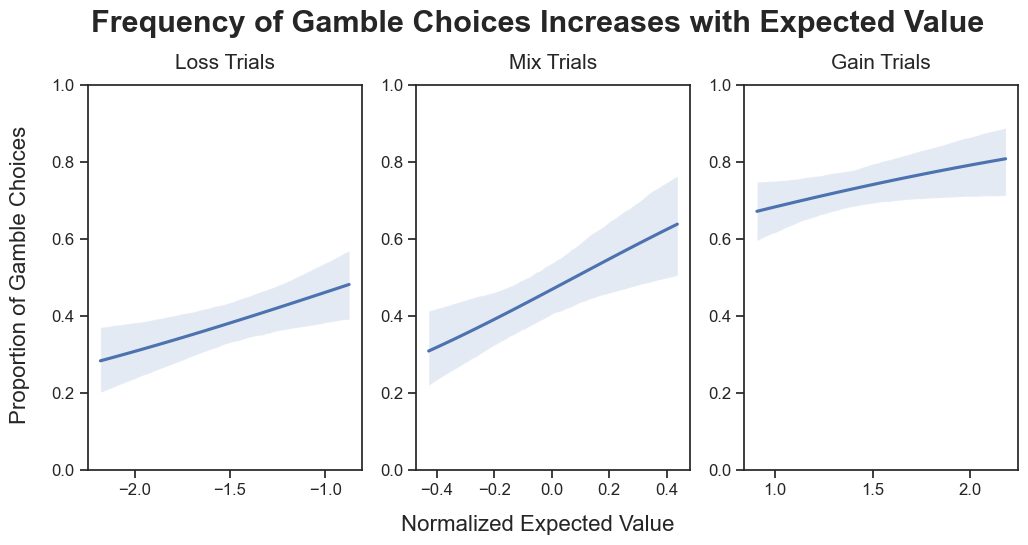

In [139]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='ocean') #crest_r
sns.regplot(data=gamble_plot,ax=ax1,x='loss_x',y='loss_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax2,x='mix_x',y='mix_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax3,x='gain_x',y='gain_y',logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.02,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.06,weight='medium',fontsize=16)
fig.suptitle('Frequency of Gamble Choices Increases with Expected Value',y=1.03,weight='semibold',fontsize=22)


# plt.savefig(f'{proj_dir}figs/swb_model_free_figs/all_subj_gamble_plot.png', dpi=300, format='png', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None)   


#### Task Behavior by bdi

In [140]:
#loading all subj task and rate df, computing norm gamble choices, saving information for plots

master_gamble_nodep = {}
master_gamble_dep = {}

for subj_id in subj_ids:
    behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
    behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
    if subj_id in dep_subj:
        loss,mix,gain = SWB_behav_utils.norm_gamble_choices(behav_df)
        master_gamble_dep[subj_id] = {'loss':loss,
                                'mix': mix,
                                'gain': gain}
    else:
        loss,mix,gain = SWB_behav_utils.norm_gamble_choices(behav_df)
        master_gamble_nodep[subj_id] = {'loss':loss,
                                'mix': mix,
                                'gain': gain}


In [141]:
gamble_plot_nodep = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

for subj_id in nodep_subj:
    data = master_gamble_nodep[subj_id]
    df={}
    df['loss_x'] = data['loss']['loss_x_axis']
    df['loss_y'] = data['loss']['loss_choice_props']

    df['mix_x'] = data['mix']['mix_x_axis']
    df['mix_y'] =  data['mix']['mix_choice_props']

    df['gain_x'] = data['gain']['gain_x_axis']
    df['gain_y'] = data['gain']['gain_choice_props']

    gamble_plot_nodep = pd.concat([gamble_plot_nodep,pd.DataFrame(df)])

gamble_plot_nodep = gamble_plot_nodep.dropna(axis=0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.05, 'Influence of Expected Value on Gamble Decision')

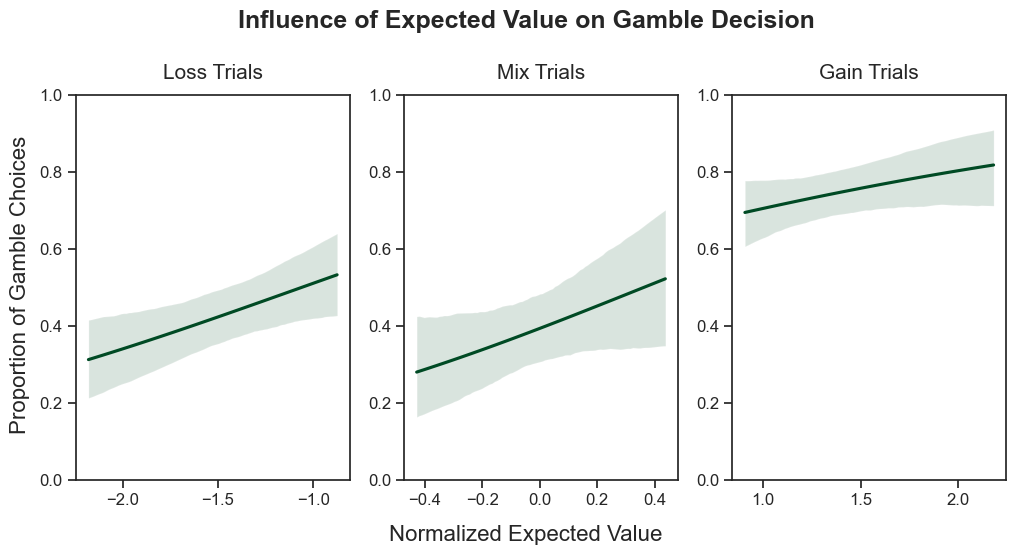

In [142]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='crest_r') 
sns.regplot(data=gamble_plot_nodep,ax=ax1,x='loss_x',y='loss_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot_nodep,ax=ax2,x='mix_x',y='mix_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot_nodep,ax=ax3,x='gain_x',y='gain_y',logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.02,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.07,weight='medium',fontsize=16)
fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

In [143]:
gamble_plot_dep = pd.DataFrame(columns=['loss_x','loss_y','mix_x','mix_y','gain_x','gain_y'])

for subj_id in dep_subj:
    data = master_gamble_dep[subj_id]
    df={}
    df['loss_x'] = data['loss']['loss_x_axis']
    df['loss_y'] = data['loss']['loss_choice_props']

    df['mix_x'] = data['mix']['mix_x_axis']
    df['mix_y'] =  data['mix']['mix_choice_props']

    df['gain_x'] = data['gain']['gain_x_axis']
    df['gain_y'] = data['gain']['gain_choice_props']

    gamble_plot_dep = pd.concat([gamble_plot_dep,pd.DataFrame(df)])

gamble_plot_dep = gamble_plot_dep.dropna(axis=0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.05, 'Influence of Expected Value on Gamble Decision')

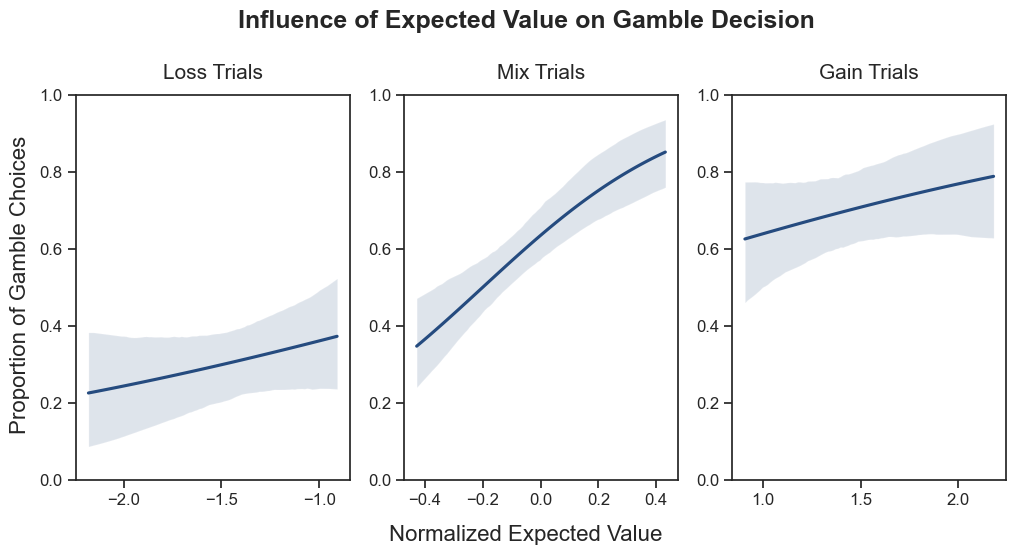

In [144]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='crest_r') 
sns.regplot(data=gamble_plot_dep,ax=ax1,x='loss_x',y='loss_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot_dep,ax=ax2,x='mix_x',y='mix_y',logistic=True,scatter=False)
sns.regplot(data=gamble_plot_dep,ax=ax3,x='gain_x',y='gain_y',logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.02,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.07,weight='medium',fontsize=16)
fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)